# All Imports 

In [1]:
# # All the imports
%pip install patchify
%pip install GPUtil
%pip install torchsummary
# %pip install torch==2.2.2 torchvision==0.17.2 

Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... - \ done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=67f243425548c1eb842f6c3f105179dd6d2db127683dc09a5e0d6a194af8f68e
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import cv2
# import random
import glob
import PIL
from PIL import Image
from tqdm import tqdm
import imghdr
from patchify import patchify 
import tifffile as tf

from GPUtil import showUtilization as gpu_usage

from skimage.segmentation import find_boundaries
import time
import torch
import torchvision
import torch.optim as optim
import albumentations as A
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import Dropout
from torchsummary import summary

from torch.nn import BatchNorm2d 
from torchvision.utils import make_grid

from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch.nn.functional import normalize

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# essential featiures 

In [3]:
# define the test split
# TEST_SPLIT = 0.3
VALIDATION_SPLIT = 0.3

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
# PIN_MEMORY = True if DEVICE == "cuda" else False

# define the number of inputchannels in the input, number of classes,
# and number of levels (start and end) in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
START_CHANEL = 16
END_CHANEL = 512
if torch.cuda.is_available() and torch.cuda.device_count() > 0:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    NUM_WORKERS = torch.cuda.device_count()
    print(NUM_WORKERS)
else : 
        NUM_WORKERS = 0 

# initialize learning rate, number of epochs to train for, and the
# batch size ( in general small batch size has 256 samples, here due to 2 batch ss we have )
INIT_LR = 1e-3
NUM_EPOCHS = 200
BATCH_SIZE = 1
PATCH_SIZE = 256
WEIGHT_DECAY = 1e-6

# define the input image dimensions
# INPUT_IMAGE_WIDTH = 2048
# INPUT_IMAGE_HEIGHT = 1536

INPUT_IMAGE_WIDTH = PATCH_SIZE
INPUT_IMAGE_HEIGHT = PATCH_SIZE
NUM_AUGMENTATION = 2

#learning rate scheduler 
Patience = 4
MAX_lr = 1e-1
BASE_lr = 1e-6
STEP_SIZE = 50

# define thresholds for early stopping, for accuracy calculation and predcitions 
EARLY_STOP_THRES = 3
best_accuracy = -1
best_epoch = -1
THRESHOLD = 0.5


plotName = f"bSz{BATCH_SIZE}_ip{PATCH_SIZE}_EnDc{START_CHANEL}-{END_CHANEL}_ep{NUM_EPOCHS}_vls{VALIDATION_SPLIT}_aug{NUM_AUGMENTATION}_nW{NUM_WORKERS}"
print(f'ModelName:-{plotName}')

BASE_OUTPUT = "/kaggle/working/"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, f"{plotName}")
# TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

# define the path to the base output directory
gpu_usage() 

Let's use 2 GPUs!
2
ModelName:-bSz1_ip256_EnDc16-512_ep200_vls0.3_aug2_nW2
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |


# important functions 

In [4]:
def plotSanityCheckImages(img1, img2, img3, name):
    
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    ax[2].imshow(img3)

    ax[0].set_title("original img")
    ax[1].set_title("mask")
    ax[2].set_title("Boundary")

    figure.suptitle(f"{name}")
    figure.tight_layout()
    figure.show()
    
def collectImagePaths(imgPath, labelPath):
    """Creates a list of image and label paths"""
    imageName = []
    labelName = []
  
    for i, image_name in enumerate(sorted(os.listdir(imgPath))):
            
        if ((('.').join(image_name.split('.')[-1:])== 'tif') or (('.').join(image_name.split('.')[-1:]) == 'tiff')):
            label_name = '.'.join(image_name.split('.')[:-1]) +  '_bn.tif'
            
            if label_name in list(os.listdir(labelPath)): 
                img_Path = os.path.join(imgPath, image_name)
                imageName.append(img_Path)
                
                label_Path = os.path.join(labelPath, label_name)
                labelName.append(label_Path)
            else:
                print(f'{image_name} doesnot have a label')
        return imageName, labelName
                    
    

def readData(imgPath, labelPath, convertType):
    """Reads and creates a list of target"""
    
    length = len(os.listdir(imgPath))
    counter = 0
  
    for i, image_name in enumerate(sorted(os.listdir(imgPath))):
            
        if ((('.').join(image_name.split('.')[-1:])== 'tif') or (('.').join(image_name.split('.')[-1:]) == 'tiff')):
            label_name = '.'.join(image_name.split('.')[:-1]) +  '_bn.tif'
            
            if label_name in list(os.listdir(labelPath)): 
                # normalise by 255.0 -> convert to array -> append to list
                img_Path = os.path.join(imgPath, image_name)
                print(img_Path)
                img = Image.open(img_Path).convert(convertType)
                img = np.array(img, dtype = np.float32)/255.0
                
                label_Path = os.path.join(labelPath, label_name)
                print(label_Path)
                label = Image.open(label_Path).convert(convertType)
                labelB = find_boundaries(np.array(label, dtype = np.uint8), mode = 'thick').astype(np.uint8)
                labelB = np.where(np.array(labelB) > 0, 1.0, 0.0)
                label = np.where(np.array(label) > 0, 1.0, 0.0)
                print(img.shape, labelB.shape)
                counter += 1 
                yield counter, (img, label, labelB, image_name)   
            else:
                continue
                print('Images with no mask-->', image_name)
        else: 
            continue
            print('Image with new extension', image_name)

def readData_length(imgPath, labelPath):
    """Reads and creates a list of target"""
    
    length = len(os.listdir(imgPath))
    counter = 0
  
    for i, image_name in enumerate(sorted(os.listdir(imgPath))):
            
        if ((('.').join(image_name.split('.')[-1:])== 'tif') or (('.').join(image_name.split('.')[-1:]) == 'tiff')):
            label_name = '.'.join(image_name.split('.')[:-1]) +  '_bn.tif'
            
            if label_name in list(os.listdir(labelPath)): 
                counter += 1 

    return counter


# creating dataset and dataloader 

In [5]:
class SpheroidDataset(Dataset):

    def __init__(self, imagePaths, maskPaths, patchSize, convertType, num_augmentations = 0, transforms = None):
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.patchSize = patchSize
        self.transforms = transforms
        self.convertType = convertType
        self.num_augmentations = num_augmentations
    
    def collectImagePaths(self, imgPath, labelPath):
        """Creates a list of image and label paths"""
        imageNames, labelNames = [], []
        for i, image_name in enumerate(sorted(os.listdir(imgPath))):
            if ((('.').join(image_name.split('.')[-1:])== 'tif') 
                or (('.').join(image_name.split('.')[-1:]) == 'tiff')):
                label_name = '.'.join(image_name.split('.')[:-1]) +  '_bn.tif'
                if label_name in list(os.listdir(labelPath)): 
                    img_Path = os.path.join(imgPath, image_name)
                    imageNames.append(img_Path)
                
                    label_Path = os.path.join(labelPath, label_name)
                    labelNames.append(label_Path)
                else:
                    print(f'{image_name} doesnot have a label')
        return imageNames, labelNames
    
    def readData(self, imgPath, labelPath, convertType):
        """"reads the image path and able path"""
        img = Image.open(imgPath).convert(convertType )
        img = np.array(img, dtype = np.float32)/255.0
        
        label = Image.open(labelPath).convert(convertType )
        labelB = find_boundaries(np.array(label, dtype = np.uint8), mode = 'thick').astype(np.uint8)
        kernel = np.ones((5, 5), np.uint8) 
        labelB = np.where(np.array(labelB) > 0, 1.0, 0.0)
        labelB = cv2.dilate(labelB, kernel, iterations = 1)
        label = np.where(np.array(label) > 0, 1.0, 0.0)
        
        return img, label, labelB
    
    def createPatches(self, img, mask, maskB, patchSize):
        """ takes the full image and divides it into resoectuve patches """
        patched_image = patchify(img, (patchSize, patchSize), step=patchSize)
        patched_mask = patchify(mask, (patchSize, patchSize), step=patchSize)
        patched_maskB = patchify(maskB, (patchSize, patchSize), step=patchSize)
        images, masks, maskBs = [], [], []
        for i in range (patched_image.shape[0]):
            for j in range (patched_image.shape[1]):
                patch_img = patched_image[i, j, :, :]
                patch_mask = patched_mask[i, j, :, :]
                patch_maskB = patched_maskB[i, j, :, :]
                
                images.append(torch.tensor(patch_img, dtype = torch.float32).unsqueeze(0))
                masks.append(torch.tensor(patch_mask, dtype = torch.float32).unsqueeze(0))
                maskBs.append(torch.tensor(patch_maskB, dtype = torch.float32).unsqueeze(0))
        return images, masks, maskBs   
    
    def dataTransform(self, image, mask, maskBoundary):
        images_list, masks_list, maskBoundary_list = [], [], []
        transform = A.Compose([
                                A.HorizontalFlip(p = 0.50),
                               A.VerticalFlip(p = 0.50),
                               A.Rotate(p=0.50),
                                A.ShiftScaleRotate(p=0.5),
#                                A.ElasticTransform(p=0.91),
                               A.GridDistortion(p = 0.50),
                              ])
        augmentations = transform(image = np.array(image), masks = [np.array(mask), np.array(maskBoundary)])
        aug = [augmentations["image"], augmentations["masks"][0], augmentations["masks"][1]]
        return aug
    
    def imperativeDataTransform(self, image, mask, maskBoundary):
        images_list, masks_list, maskBoundary_list = [], [], []
        transform = A.Compose([A.GridDistortion(p = 1, num_steps = 10),
                              ])
        augmentations = transform(image = np.array(image), masks = [np.array(mask), np.array(maskBoundary)])
        aug = [augmentations["image"], augmentations["masks"][0], augmentations["masks"][1]]
        return aug
        

    def __len__(self):
        totalImages, totalMasks = self.collectImagePaths(self.imagePaths, self.maskPaths)
        
        if self.num_augmentations > 1:
            length = len(totalImages)* self.num_augmentations
        else:
            length = len(totalImages)
        return length

    def __getitem__(self, idx):
        # read data from the index
        totalImages, totalMasks = self.collectImagePaths(self.imagePaths, self.maskPaths)
        
        # mandatory transformation 
        if self.num_augmentations > 1:
            idx = idx // self.num_augmentations
            ImageDatas = self.readData(totalImages[idx], totalMasks[idx], self.convertType )
            name = totalImages[idx].split('/')[-1:]
            if (idx % self.num_augmentations) != 0: 
                ImageDatas = self.imperativeDataTransform(ImageDatas[0], ImageDatas[1], ImageDatas[2])
        else:
            ImageDatas = self.readData(totalImages[idx], totalMasks[idx], self.convertType )
            name = totalImages[idx].split('/')[-1:]
        
        # perform transfromation 
        if self.transforms == True: #and (idx % self.num_augmentations) == 0:
            ImageDatas = self.dataTransform(ImageDatas[0], ImageDatas[1], ImageDatas[2])
            
        # perform patch creation
        img, mask, maskB = self.createPatches(ImageDatas[0], ImageDatas[1], ImageDatas[2], self.patchSize)
        
        return img, mask, maskB, name
    

#         return image_patch, mask_patch, maskBoundary_patch
PATCH_SIZE = 256
input_folder = '/kaggle/input/myofarm/test_inputs'
label_folder = '/kaggle/input/myofarm/test_masks'
numAug = 0
train_dataset = SpheroidDataset(input_folder, label_folder, patchSize = PATCH_SIZE, 
                          convertType = "L") #, num_augmentations = 0, transforms = True)
print(f'dataset length {len(train_dataset)}')
# SpheroidDataset.readData()

for i, item in enumerate(train_dataset):
    print(f'data index-{i}, -> total #{len(item)}item, -> has #{len(item[0])}patches -> with shape{item[0][0].shape}')
    img =item[0][4].squeeze().numpy()
    mask =item[1][4].squeeze().numpy()
    maskB =item[2][4].squeeze().numpy()
    name = item[3]
    
    # plotSanityCheckImages(item[0], item[1], item[2], f"{item[3]}" )
#     plotSanityCheckImages(img, mask, maskB, f"{item[3]}" ) 
    if i == 2: break


dataset length 3
data index-0, -> total #4item, -> has #48patches -> with shapetorch.Size([1, 256, 256])
data index-1, -> total #4item, -> has #48patches -> with shapetorch.Size([1, 256, 256])
data index-2, -> total #4item, -> has #48patches -> with shapetorch.Size([1, 256, 256])


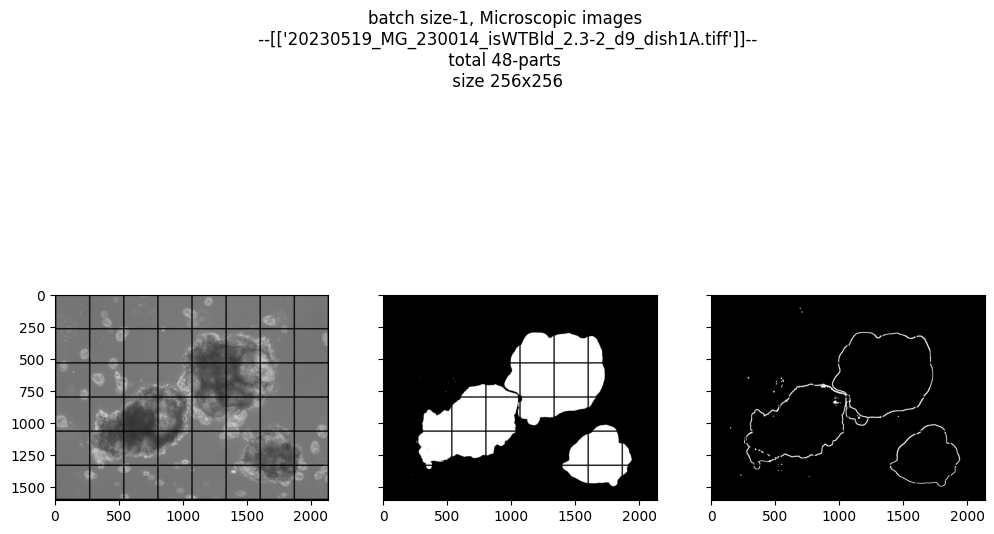

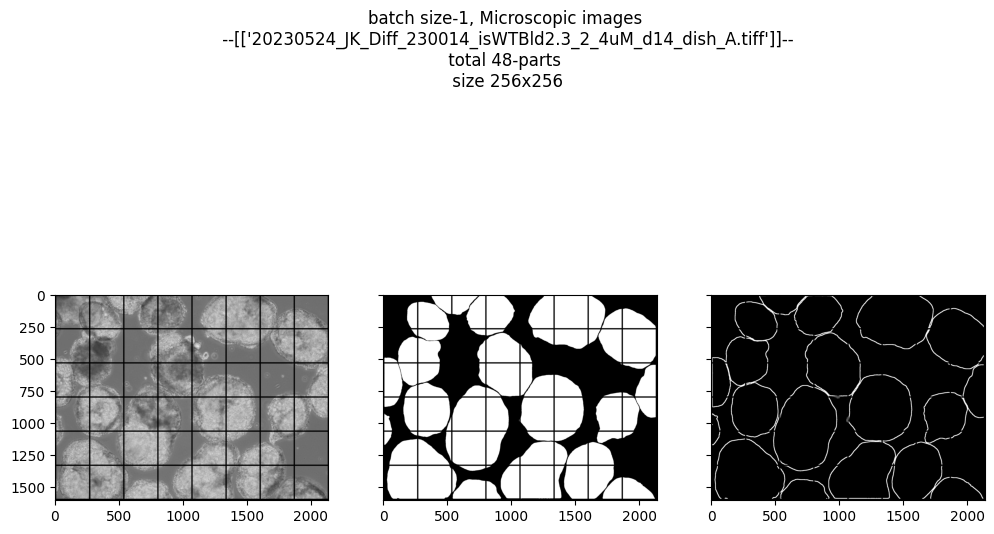

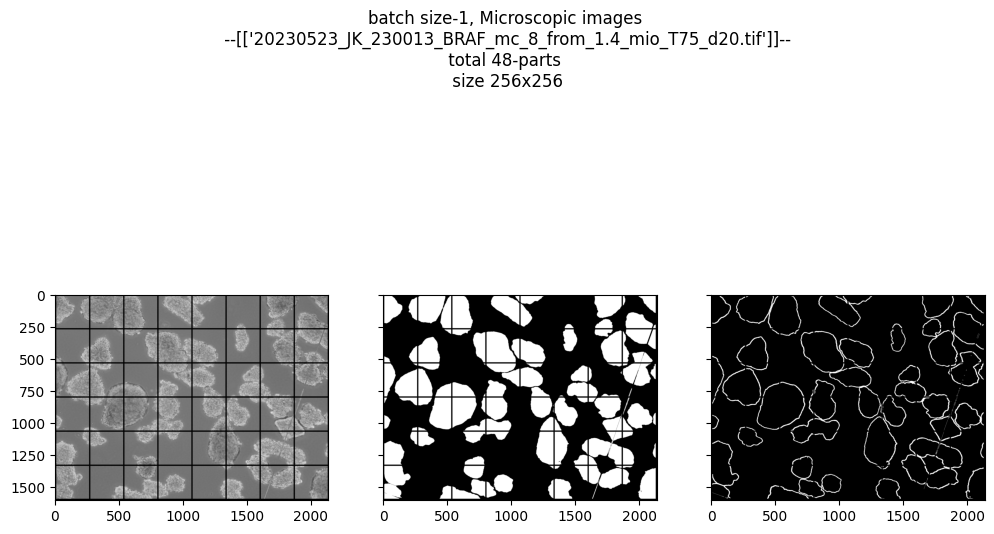

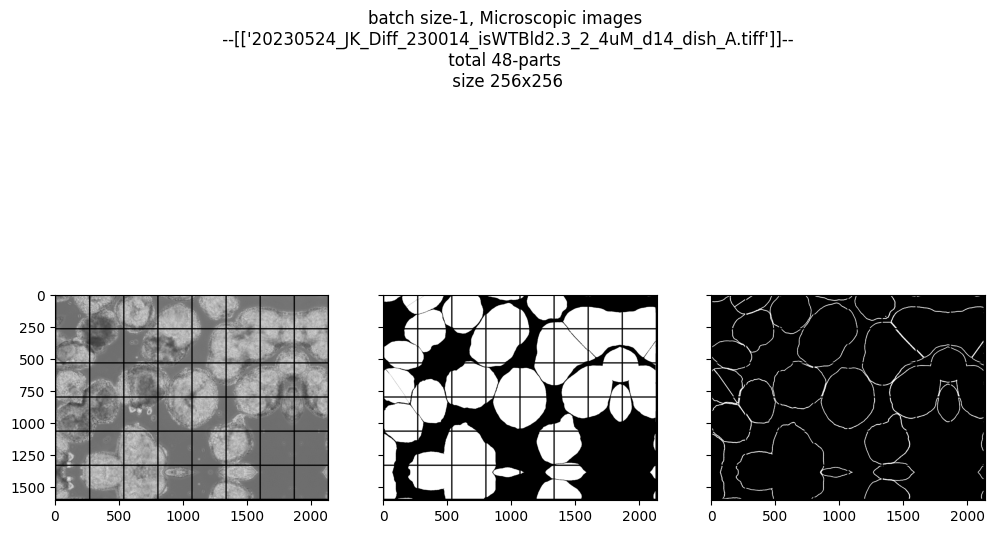

In [6]:
def custom_collate_fn(batch):
    _images, _masks, _maskBs, name = [], [], [], []
    for i, items in enumerate(batch):
        _images.extend(items[0])
        _masks.extend(items[1])
        _maskBs.extend(items[2])
        name.append(items[3])

    images = torch.stack(_images, dim = 0)
    masks = torch.stack(_masks, dim = 0)
    maskBs = torch.stack(_maskBs, dim = 0)
        
    return (images, masks, maskBs), name


def show_batch(data_loader, batch, patchSize, _showMore = None):
    """Plot images grid of single batch"""
    for i, (item, name) in enumerate(data_loader):
        wrapped_title = str(name).replace(", ", ",\n")
#         print(f'{i+1} -> batch, with images {name},\n  -> with each items patched into-{len(item[0])} parts')
        images = item[0]
        mask = item[1]
        maskB = item[2]
        figure, ax = plt.subplots(nrows=1, ncols=3, figsize = (12, 8), sharex=True, sharey=True)
        figure.suptitle(f"batch size-{batch}, Microscopic images\n --{wrapped_title}--\n total {len(item[0])}-parts \n size {patchSize}x{patchSize}", fontsize = 12)
        ax[0].imshow(make_grid(images, nrow = 2*4, padding = 10).permute(1,2,0)) # b is from batch size above cell
        ax[1].imshow(make_grid(mask, nrow = 2*4, padding = 10).permute(1,2,0))
        ax[2].imshow(make_grid(maskB, nrow = 2*4, padding = 10).permute(1,2,0))
        plt.tight_layout
        if (i == 1) and (_showMore == False) :
            break 
            
PATCH_SIZE = 256
BATCH_SIZE = 1
valSplit = 0.3

input_folder = '/kaggle/input/myofarm/test_inputs'
label_folder = '/kaggle/input/myofarm/test_masks'
numAug = 0

train_dataset = SpheroidDataset(input_folder, label_folder, patchSize = PATCH_SIZE, 
                                convertType = "L", num_augmentations = 2, transforms = True)

train_set, validation_set = torch.utils.data.random_split(train_dataset, 
                                                          [round(len(train_dataset) * (1 - valSplit)), 
                                                           round(len(train_dataset) * valSplit)])

trainLoader = DataLoader(dataset = train_set, batch_size = BATCH_SIZE, 
                         collate_fn = custom_collate_fn, num_workers = 0, shuffle =True)
validationLoader = DataLoader(dataset = validation_set, batch_size = BATCH_SIZE, 
                              collate_fn = custom_collate_fn, num_workers = 2, shuffle =True) 

show_batch(trainLoader, batch = BATCH_SIZE, patchSize = PATCH_SIZE, _showMore = True)


# loss functions 

In [7]:
def modelAccuracy(pred, targets):
    # Calculate pixel-wise accuracy
    # assuming input and targets afe falttened
    threshold = 0.5

    targets = torch.where(targets > threshold, torch.tensor(1), torch.tensor(0))
    pred = torch.where(pred > threshold, torch.tensor(1), torch.tensor(0))

    correct = (pred == targets)
    accuracy = correct.sum() / targets.numel()
    
    return accuracy


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, pred, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        pred = pred.view(-1)
        targets = targets.view(-1)
        
        intersection = (pred * targets).sum()                            
        dice = (2.*intersection + smooth)/(pred.sum() + targets.sum() + smooth) 
        accuracy = modelAccuracy(pred, targets)
        
        return 1 - dice, accuracy
    
    
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, pred, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        pred = pred.view(-1)
        targets = targets.view(-1)
        
        intersection = (pred * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(pred.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(pred, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        accuracy = modelAccuracy(pred, targets)
        
        return Dice_BCE, accuracy
    
#PyTorch
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    # loss = model_lossFunc(pred.to(torch.float32), y.to(torch.float32))
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, pred, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        pred = pred.view(-1) #model_predictions
        targets = targets.view(-1) #originalMasks
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(pred, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
        
        accuracy = modelAccuracy(pred, targets)
                       
        return focal_loss, accuracy

# building the mdoel 

In [8]:
def UNETchannels(startChanel, endChanel, num_chanel = NUM_CHANNELS):
    startPower = int(math.log2(startChanel))
    endPower = int(math.log2(endChanel))
    enCh = [num_chanel]
    deCh = []
    for num in range(startPower, endPower+1):
        enCh.append(2**num)
    deCh = enCh[::-1]
    deCh.pop()
    return tuple(enCh), tuple(deCh)

# START_CHANEL = 16
# END_CHANEL = 1024
enCh, deCh = UNETchannels(START_CHANEL, END_CHANEL)


class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        self.conv1 = nn.Conv2d(inChannels, outChannels,
                            kernel_size=3, stride=1, padding=1, bias=True)
        self.BN1 = nn.BatchNorm2d(outChannels)
        self.relu1 = nn.ReLU(inplace = True)
        self.dropout = nn.Dropout(0.25)
            
        self.conv2 = Conv2d(outChannels, outChannels, 
                            kernel_size=3, stride=1, padding=1, bias=True)
        self.BN2 = BatchNorm2d(outChannels)
        self.relu2 = ReLU(inplace = True)
        
    def forward(self, x):
        # apply CONV => [BN] => RELU => CONV block to the inputs and return it
        outputConv1 = self.dropout(self.relu1(self.BN1(self.conv1(x))))
        outputConv2 = self.relu2(self.BN2(self.conv2(outputConv1))) 
        return outputConv2

In [9]:
class Encoder(Module):    
    def __init__(self, channels = enCh): 
        super().__init__()
        self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) 
                                      for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x): 
        blockOutputs = []
        for block in self.encBlocks:
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)

        return blockOutputs
    
    
class DecoderB(Module):
    def __init__(self, channels = deCh):
        super().__init__()

        self.channels = channels
        self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2)
                                   for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1])
                                       for i in range(len(channels) - 1)])

    def forward(self, x, encFeatures):

        for i in range(len(self.channels) - 1):
            x = self.upconvs[i](x)
            x = torch.cat([x, encFeatures[i]], dim=1)
            x = self.dec_blocks[i](x)

        return x
    
class Decoder(Module):
    def __init__(self, channels = deCh):
        super().__init__()

        self.channels = channels
        self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2)
                                   for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1])
                                       for i in range(len(channels) - 1)])

    def forward(self, x, encFeatures):

        for i in range(len(self.channels) - 1):
            x = self.upconvs[i](x)
            x = torch.cat([x, encFeatures[i]], dim=1)
            x = self.dec_blocks[i](x)

        return x 

class UNet(Module):
        
    def __init__(self, encChannels = enCh,
                 decChannels = deCh, 
                 nbClasses=1, retainDim=True,
                 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        self.head = nn.Sequential(nn.Conv2d(decChannels[-1], nbClasses, kernel_size=1),
                                  nn.Sigmoid())
        
        self.decoderB = DecoderB(decChannels)
        self.headB = nn.Sequential(nn.Conv2d(decChannels[-1], nbClasses, kernel_size=1),
                                  nn.Sigmoid())
        self.retainDim = retainDim
        self.outSize = outSize
        
        
    def forward(self, x):
        encFeatures = self.encoder(x)
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        mapS = self.head(decFeatures)
        
        decFeaturesB = self.decoderB(encFeatures[::-1][0], encFeatures[::-1][1:])
        mapB = self.headB(decFeaturesB)
        
        if self.retainDim:
            mapS = F.interpolate(mapS, self.outSize)
            mapB = F.interpolate(mapB, self.outSize)

        return mapS, mapB  
from torchsummary import summary
summary(UNet().to(DEVICE), input_size=(1,PATCH_SIZE,PATCH_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
           Dropout-4         [-1, 16, 256, 256]               0
            Conv2d-5         [-1, 16, 256, 256]           2,320
       BatchNorm2d-6         [-1, 16, 256, 256]              32
              ReLU-7         [-1, 16, 256, 256]               0
             Block-8         [-1, 16, 256, 256]               0
         MaxPool2d-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 32, 128, 128]           4,640
      BatchNorm2d-11         [-1, 32, 128, 128]              64
             ReLU-12         [-1, 32, 128, 128]               0
          Dropout-13         [-1, 32, 128, 128]               0
           Conv2d-14         [-1, 32, 1

# model features and paramerts 

In [10]:
BATCH_SIZE = 1
valSplit = 0.3
# NUM_WORKERS
PATCH_SIZE = 256

input_folder = '/kaggle/input/myofarm/Images_input'
label_folder = '/kaggle/input/myofarm/Images_target'

# train_dataset_1 = SpheroidDataset(input_folder, label_folder,patchSize = PatchSize, transforms = False)
# train_dataset_2 = SpheroidDataset(input_folder, label_folder,patchSize = PatchSize, transforms = True)
from torch.utils.data import ConcatDataset

# train_dataset = ConcatDataset([train_dataset_1, train_dataset_2])
# train_dataset = SpheroidDataset(input_folder, label_folder,patchSize = PatchSize, transforms = False)
train_dataset = SpheroidDataset(input_folder, label_folder, patchSize = PATCH_SIZE, 
                                convertType = "L", num_augmentations = 2, transforms = True)

train_set, validation_set = torch.utils.data.random_split(train_dataset, 
                                                          [round(len(train_dataset) * (1 - valSplit)), 
                                                           round(len(train_dataset) * valSplit)])


trainLoader = DataLoader(dataset = train_set, batch_size = BATCH_SIZE, 
                         collate_fn = custom_collate_fn, num_workers = 2, shuffle = True)
validationLoader = DataLoader(dataset = validation_set, batch_size = BATCH_SIZE, 
                              collate_fn = custom_collate_fn, num_workers = 2, shuffle =True) 

# calculate steps per epoch for training and test set

trainSteps = len(train_set) // BATCH_SIZE
validationSteps = len(validation_set) // BATCH_SIZE

print(f"Total {len(train_set)} instances in the training and {trainSteps} per epoch")
print(f"Total {len(validation_set)} instances in the validation set and {validationSteps} per epoch")
print(f"Each Epoch runs: {len(trainLoader)} times, where each loader has {BATCH_SIZE} instances for trainig")
# print(f"ModelName-{plotName}\n")

unet = UNet()
model = nn.DataParallel(unet)
model.to(DEVICE)
# initialize loss function and optimizerimizer
metric_lossFunc = DiceBCELoss() #nn.BCELoss() #
boundaryLoss = DiceLoss() #FocalLoss() #DiceLoss()
optimizer = optim.Adam(model.parameters(), lr= 1e-4, weight_decay = 1e-6)

print(trainSteps, validationSteps)
print(DEVICE)

Total 171 instances in the training and 171 per epoch
Total 73 instances in the validation set and 73 per epoch
Each Epoch runs: 171 times, where each loader has 1 instances for trainig
171 73
cuda


In [11]:
def save_checkpoint(_model = None, _modelName = None, _file_path = None):
    print(" =====> Saving the complete model")
    if _file_path == None: 
        _file_path = pwd() + f"/{_modelName}_FullModel.pth"
    else: 
        _file_path = _file_path + f"/{_modelName}_FullModel.pth"
    torch.save(_model, _file_path)
    return _file_path

def plotLossAccResults(_train_loss, _test_loss, _test_acc, _modelName):
    plt.figure(figsize=(10, 4))
    plt.style.use("ggplot")

    plt.plot(_train_loss, label="train_loss", marker='d')
    plt.plot(_test_loss, label="test_loss", marker='p')
    plt.plot(_test_acc, label="test_accuracy", marker='o')

    plt.title(f"Cysticity Model Results \n{_modelName}\ntestAccuracy-{_test_acc[-1]:.2f}") 
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.xticks(np.arange(0, len(train_loss), 1))
#     plt.yticks(np.arange(0, max(test_loss), 0.1))

    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show()
    return

def trainLoop(epoch, _dataLoader, model, device):
    model.train()
    total_loss, total_accuracy = 0, 0
    b_loss = 0
    for i, (batch, name) in enumerate(_dataLoader):
        # print(batch[0])
        img = batch[0].to(device)
        mask = batch[1].to(device)
        maskB = batch[2].to(device)
        
        mask_pred, boundary_pred = model(img)
        loss, accuracy = metric_lossFunc(mask_pred, mask)
        lossB, accuracyB = boundaryLoss(boundary_pred, maskB)
        combined_loss = loss + lossB

        optimizer.zero_grad()
        combined_loss.backward()
        optimizer.step()

        total_loss += combined_loss.item()
        b_loss += lossB.item()
        total_accuracy += accuracy.item() + accuracyB.item()
#     print(f'Training epoch-{epoch+1}, total_loss-{total_loss/len(_dataLoader)}, boundaryLoss-{b_loss/len(_dataLoader)}')
    return total_loss/len(_dataLoader), total_accuracy/len(_dataLoader)


def validationLoop(epoch, _dataLoader, model, device):
    total_loss, total_accuracy = 0, 0
    b_loss = 0
    model.eval()
    with torch.no_grad():        
        for i, (batch, name) in enumerate(_dataLoader):              
            # print(batch[0])
            img = batch[0].to(device)
            mask = batch[1].to(device)
            maskB = batch[2].to(device)
            
            mask_pred, boundary_pred = model(img)
            loss, accuracy = metric_lossFunc(mask_pred, mask)
            lossB, accuracyB = boundaryLoss(boundary_pred, maskB)
            combined_loss = loss + lossB
            
            b_loss += lossB.item()
            total_loss += combined_loss.item()
            total_accuracy += accuracy.item() + accuracyB.item()
#     print(f'Validation epoch-{epoch+1}, total_loss-{total_loss/len(_dataLoader)}, boundaryLoss-{b_loss/len(_dataLoader)}') #, total_accuracy-{total_accuracy/len(_dataLoader)}')
    return total_loss/len(_dataLoader), total_accuracy/len(_dataLoader)
    
        


  0%|          | 0/200 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
  1%|          | 2/200 [03:32<5:50:54, 106.33s/it]

 =====> Saving the complete model


  2%|▏         | 4/200 [07:07<5:50:16, 107.23s/it]

 =====> Saving the complete model


  2%|▎         | 5/200 [08:55<5:49:41, 107.60s/it]


epoch: 5/200
 -->train_Loss: 1.29564
 -->test_Loss: 2.04863


  3%|▎         | 6/200 [10:43<5:47:32, 107.49s/it]

 =====> Saving the complete model


  4%|▍         | 8/200 [14:17<5:43:52, 107.46s/it]

 =====> Saving the complete model


  5%|▌         | 10/200 [17:52<5:39:36, 107.25s/it]

 =====> Saving the complete model


  6%|▌         | 12/200 [21:27<5:36:24, 107.37s/it]

 =====> Saving the complete model


  7%|▋         | 14/200 [25:01<5:32:14, 107.17s/it]

 =====> Saving the complete model


  8%|▊         | 15/200 [26:46<5:28:33, 106.56s/it]


epoch: 15/200
 -->train_Loss: 0.75009
 -->test_Loss: 1.26343


  8%|▊         | 16/200 [28:32<5:26:52, 106.59s/it]

 =====> Saving the complete model


  9%|▉         | 18/200 [32:06<5:23:41, 106.71s/it]

 =====> Saving the complete model


 10%|█         | 20/200 [35:39<5:19:31, 106.51s/it]

 =====> Saving the complete model


 11%|█         | 22/200 [39:12<5:15:59, 106.51s/it]

 =====> Saving the complete model


 12%|█▏        | 24/200 [42:44<5:11:52, 106.32s/it]

 =====> Saving the complete model


 12%|█▎        | 25/200 [44:30<5:10:02, 106.30s/it]


epoch: 25/200
 -->train_Loss: 0.50383
 -->test_Loss: 0.88733


 13%|█▎        | 26/200 [46:18<5:09:09, 106.61s/it]

 =====> Saving the complete model


 14%|█▍        | 28/200 [49:48<5:03:34, 105.90s/it]

 =====> Saving the complete model


 15%|█▌        | 30/200 [53:21<5:01:05, 106.27s/it]

 =====> Saving the complete model


 16%|█▌        | 32/200 [56:54<4:57:59, 106.42s/it]

 =====> Saving the complete model


 17%|█▋        | 34/200 [1:00:27<4:54:03, 106.28s/it]

 =====> Saving the complete model


 18%|█▊        | 35/200 [1:02:13<4:52:34, 106.39s/it]


epoch: 35/200
 -->train_Loss: 0.44299
 -->test_Loss: 0.77669


 18%|█▊        | 36/200 [1:04:01<4:51:44, 106.73s/it]

 =====> Saving the complete model


 19%|█▉        | 38/200 [1:07:34<4:47:48, 106.60s/it]

 =====> Saving the complete model


 20%|██        | 40/200 [1:11:05<4:42:52, 106.08s/it]

 =====> Saving the complete model


 21%|██        | 42/200 [1:14:38<4:39:59, 106.33s/it]

 =====> Saving the complete model


 22%|██▏       | 44/200 [1:18:11<4:36:29, 106.34s/it]

 =====> Saving the complete model


 22%|██▎       | 45/200 [1:19:56<4:34:00, 106.07s/it]


epoch: 45/200
 -->train_Loss: 0.40327
 -->test_Loss: 0.78932


 23%|██▎       | 46/200 [1:21:43<4:32:30, 106.17s/it]

 =====> Saving the complete model


 24%|██▍       | 48/200 [1:25:17<4:29:52, 106.53s/it]

 =====> Saving the complete model


 25%|██▌       | 50/200 [1:28:46<4:24:33, 105.83s/it]

 =====> Saving the complete model


 26%|██▌       | 52/200 [1:32:20<4:22:09, 106.28s/it]

 =====> Saving the complete model


 27%|██▋       | 54/200 [1:35:53<4:19:12, 106.53s/it]

 =====> Saving the complete model


 28%|██▊       | 55/200 [1:37:40<4:17:34, 106.58s/it]


epoch: 55/200
 -->train_Loss: 0.38454
 -->test_Loss: 0.75107


 28%|██▊       | 56/200 [1:39:27<4:16:07, 106.72s/it]

 =====> Saving the complete model


 29%|██▉       | 58/200 [1:43:01<4:12:56, 106.87s/it]

 =====> Saving the complete model


 30%|███       | 60/200 [1:46:34<4:08:53, 106.67s/it]

 =====> Saving the complete model


 31%|███       | 62/200 [1:50:06<4:04:45, 106.42s/it]

 =====> Saving the complete model


 32%|███▏      | 64/200 [1:53:38<4:00:33, 106.13s/it]

 =====> Saving the complete model


 32%|███▎      | 65/200 [1:55:24<3:59:11, 106.31s/it]


epoch: 65/200
 -->train_Loss: 0.38139
 -->test_Loss: 0.55674


 33%|███▎      | 66/200 [1:57:10<3:57:18, 106.26s/it]

 =====> Saving the complete model


 34%|███▍      | 68/200 [2:00:41<3:52:51, 105.85s/it]

 =====> Saving the complete model


 35%|███▌      | 70/200 [2:04:14<3:50:00, 106.15s/it]

 =====> Saving the complete model


 36%|███▌      | 72/200 [2:07:45<3:45:46, 105.84s/it]

 =====> Saving the complete model


 37%|███▋      | 74/200 [2:11:18<3:42:39, 106.03s/it]

 =====> Saving the complete model


 38%|███▊      | 75/200 [2:13:04<3:41:10, 106.17s/it]


epoch: 75/200
 -->train_Loss: 0.37323
 -->test_Loss: 0.49644


 38%|███▊      | 76/200 [2:14:51<3:39:32, 106.23s/it]

 =====> Saving the complete model


 39%|███▉      | 78/200 [2:18:23<3:35:47, 106.13s/it]

 =====> Saving the complete model


 40%|████      | 80/200 [2:21:55<3:32:16, 106.14s/it]

 =====> Saving the complete model


 41%|████      | 82/200 [2:25:25<3:27:39, 105.59s/it]

 =====> Saving the complete model


 42%|████▏     | 84/200 [2:28:58<3:25:12, 106.14s/it]

 =====> Saving the complete model


 42%|████▎     | 85/200 [2:30:43<3:23:03, 105.94s/it]


epoch: 85/200
 -->train_Loss: 0.36965
 -->test_Loss: 0.56888


 43%|████▎     | 86/200 [2:32:30<3:21:26, 106.02s/it]

 =====> Saving the complete model


 44%|████▍     | 88/200 [2:36:00<3:17:07, 105.60s/it]

 =====> Saving the complete model


 44%|████▍     | 89/200 [2:37:47<3:15:51, 105.87s/it]

 =====> Saving the complete model


 46%|████▌     | 92/200 [2:43:04<3:10:20, 105.74s/it]

 =====> Saving the complete model


 47%|████▋     | 94/200 [2:46:35<3:06:58, 105.83s/it]

 =====> Saving the complete model


 48%|████▊     | 95/200 [2:48:22<3:05:50, 106.19s/it]


epoch: 95/200
 -->train_Loss: 0.35771
 -->test_Loss: 0.56151


 48%|████▊     | 96/200 [2:50:08<3:03:51, 106.08s/it]

 =====> Saving the complete model


 49%|████▉     | 98/200 [2:53:41<3:00:25, 106.14s/it]

 =====> Saving the complete model


 50%|█████     | 100/200 [2:57:13<2:56:46, 106.07s/it]

 =====> Saving the complete model


 51%|█████     | 102/200 [3:00:45<2:53:09, 106.02s/it]

 =====> Saving the complete model


 52%|█████▏    | 104/200 [3:04:18<2:49:56, 106.22s/it]

 =====> Saving the complete model


 52%|█████▎    | 105/200 [3:06:04<2:47:56, 106.07s/it]


epoch: 105/200
 -->train_Loss: 0.34883
 -->test_Loss: 0.47143


 53%|█████▎    | 106/200 [3:07:50<2:46:14, 106.11s/it]

 =====> Saving the complete model


 54%|█████▍    | 108/200 [3:11:20<2:41:40, 105.44s/it]

 =====> Saving the complete model


 55%|█████▌    | 110/200 [3:14:52<2:38:30, 105.67s/it]

 =====> Saving the complete model


 56%|█████▌    | 112/200 [3:18:24<2:35:27, 105.99s/it]

 =====> Saving the complete model


 57%|█████▋    | 114/200 [3:21:57<2:32:09, 106.15s/it]

 =====> Saving the complete model


 57%|█████▊    | 115/200 [3:23:43<2:30:19, 106.11s/it]


epoch: 115/200
 -->train_Loss: 0.34915
 -->test_Loss: 0.49618


 58%|█████▊    | 116/200 [3:25:31<2:29:16, 106.62s/it]

 =====> Saving the complete model


 59%|█████▉    | 118/200 [3:29:04<2:25:36, 106.55s/it]

 =====> Saving the complete model


 60%|██████    | 120/200 [3:32:37<2:21:55, 106.44s/it]

 =====> Saving the complete model


 61%|██████    | 122/200 [3:36:10<2:18:47, 106.77s/it]

 =====> Saving the complete model


 62%|██████▏   | 124/200 [3:39:45<2:15:28, 106.96s/it]

 =====> Saving the complete model


 62%|██████▎   | 125/200 [3:41:31<2:13:26, 106.75s/it]


epoch: 125/200
 -->train_Loss: 0.34188
 -->test_Loss: 0.46103


 63%|██████▎   | 126/200 [3:43:18<2:11:34, 106.68s/it]

 =====> Saving the complete model


 64%|██████▍   | 128/200 [3:46:50<2:07:55, 106.60s/it]

 =====> Saving the complete model


 65%|██████▌   | 130/200 [3:50:22<2:03:52, 106.18s/it]

 =====> Saving the complete model


 66%|██████▌   | 132/200 [3:53:56<2:00:45, 106.54s/it]

 =====> Saving the complete model


 67%|██████▋   | 134/200 [3:57:29<1:57:12, 106.55s/it]

 =====> Saving the complete model


 68%|██████▊   | 135/200 [3:59:15<1:55:04, 106.22s/it]


epoch: 135/200
 -->train_Loss: 0.33898
 -->test_Loss: 0.46662


 68%|██████▊   | 136/200 [4:00:59<1:52:52, 105.81s/it]

 =====> Saving the complete model


 69%|██████▉   | 138/200 [4:04:33<1:49:51, 106.32s/it]

 =====> Saving the complete model


 70%|███████   | 140/200 [4:08:06<1:46:25, 106.42s/it]

 =====> Saving the complete model


 71%|███████   | 142/200 [4:11:39<1:42:53, 106.45s/it]

 =====> Saving the complete model


 72%|███████▏  | 144/200 [4:15:13<1:39:38, 106.76s/it]

 =====> Saving the complete model


 72%|███████▎  | 145/200 [4:16:58<1:37:31, 106.40s/it]


epoch: 145/200
 -->train_Loss: 0.34082
 -->test_Loss: 0.44665


 73%|███████▎  | 146/200 [4:18:44<1:35:37, 106.25s/it]

 =====> Saving the complete model


 74%|███████▍  | 148/200 [4:22:16<1:31:54, 106.05s/it]

 =====> Saving the complete model


 75%|███████▌  | 150/200 [4:25:49<1:28:43, 106.48s/it]

 =====> Saving the complete model


 76%|███████▌  | 152/200 [4:29:22<1:25:11, 106.49s/it]

 =====> Saving the complete model


 77%|███████▋  | 154/200 [4:32:54<1:21:37, 106.46s/it]

 =====> Saving the complete model


 78%|███████▊  | 155/200 [4:34:42<1:20:01, 106.70s/it]


epoch: 155/200
 -->train_Loss: 0.34153
 -->test_Loss: 0.48858


 78%|███████▊  | 156/200 [4:36:29<1:18:26, 106.96s/it]

 =====> Saving the complete model


 79%|███████▉  | 158/200 [4:40:02<1:14:38, 106.64s/it]

 =====> Saving the complete model


 80%|████████  | 160/200 [4:43:35<1:11:09, 106.73s/it]

 =====> Saving the complete model


 81%|████████  | 162/200 [4:47:07<1:07:17, 106.25s/it]

 =====> Saving the complete model


 82%|████████▏ | 164/200 [4:50:40<1:03:50, 106.39s/it]

 =====> Saving the complete model


 82%|████████▎ | 165/200 [4:52:25<1:01:55, 106.16s/it]


epoch: 165/200
 -->train_Loss: 0.33224
 -->test_Loss: 0.50653


 83%|████████▎ | 166/200 [4:54:11<1:00:07, 106.11s/it]

 =====> Saving the complete model


 84%|████████▍ | 168/200 [4:57:43<56:34, 106.08s/it]

 =====> Saving the complete model


 85%|████████▌ | 170/200 [5:01:15<53:00, 106.01s/it]

 =====> Saving the complete model


 86%|████████▌ | 172/200 [5:04:47<49:26, 105.96s/it]

 =====> Saving the complete model


 87%|████████▋ | 174/200 [5:08:18<45:53, 105.92s/it]

 =====> Saving the complete model


 88%|████████▊ | 175/200 [5:10:04<44:07, 105.91s/it]


epoch: 175/200
 -->train_Loss: 0.33903
 -->test_Loss: 0.47253


 88%|████████▊ | 176/200 [5:11:50<42:21, 105.88s/it]

 =====> Saving the complete model


 89%|████████▉ | 178/200 [5:15:21<38:47, 105.78s/it]

 =====> Saving the complete model


 90%|█████████ | 180/200 [5:18:55<35:26, 106.34s/it]

 =====> Saving the complete model


 91%|█████████ | 182/200 [5:22:27<31:48, 106.02s/it]

 =====> Saving the complete model


 92%|█████████▏| 184/200 [5:26:00<28:21, 106.33s/it]

 =====> Saving the complete model


 92%|█████████▎| 185/200 [5:27:45<26:29, 105.94s/it]


epoch: 185/200
 -->train_Loss: 0.32759
 -->test_Loss: 0.45520


 93%|█████████▎| 186/200 [5:29:32<24:46, 106.17s/it]

 =====> Saving the complete model


 94%|█████████▍| 188/200 [5:33:03<21:10, 105.85s/it]

 =====> Saving the complete model


 95%|█████████▌| 190/200 [5:36:35<17:38, 105.87s/it]

 =====> Saving the complete model


 96%|█████████▌| 192/200 [5:40:07<14:08, 106.12s/it]

 =====> Saving the complete model


 97%|█████████▋| 194/200 [5:43:40<10:37, 106.17s/it]

 =====> Saving the complete model


 98%|█████████▊| 195/200 [5:45:26<08:50, 106.04s/it]


epoch: 195/200
 -->train_Loss: 0.32365
 -->test_Loss: 0.48145


 98%|█████████▊| 196/200 [5:47:12<07:04, 106.16s/it]

 =====> Saving the complete model


 99%|█████████▉| 198/200 [5:50:45<03:32, 106.40s/it]

 =====> Saving the complete model


100%|██████████| 200/200 [5:54:18<00:00, 106.29s/it]

 =====> Saving the complete model


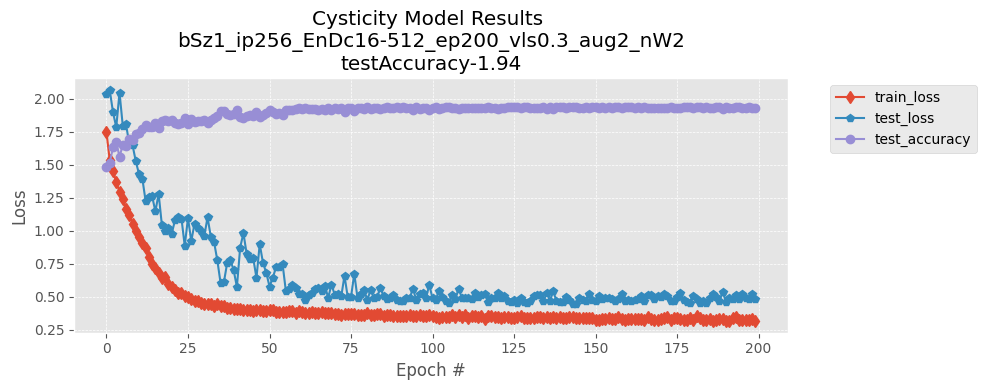

bSz1_ip256_EnDc16-512_ep200_vls0.3_aug2_nW2
| ID | GPU | MEM |
------------------
|  0 | 35% |  3% |
|  1 |  0% |  1% |
None


In [12]:
train_loss, train_acc = [], []
test_loss, test_acc = [], []
NUM_EPOCHS = 200
for epoch in tqdm(range(NUM_EPOCHS)):

    loss, acc = trainLoop(epoch, trainLoader, model, DEVICE)
    train_loss.append(loss)
    train_acc.append(acc)

    loss, acc = validationLoop(epoch, validationLoader, model, DEVICE)
    test_loss.append(loss)
    test_acc.append(acc)

    if (epoch+1)%2 == 0:
        modelFilePath = save_checkpoint(_model = model, _modelName = plotName, _file_path = BASE_OUTPUT) 
    elif (epoch+1)%5 == 0:
        print(f'\nepoch: {epoch+1}/{NUM_EPOCHS}\n -->train_Loss: {train_loss[epoch]:.5f}\n -->test_Loss: {test_loss[epoch]:.5f}') #\n -->test_acc: {test_acc[epoch]:.5f}\n')
        
plotLossAccResults(train_loss, test_loss, test_acc, _modelName = plotName)
print(plotName)   
with torch.no_grad():
    torch.cuda.empty_cache()
print(gpu_usage())

# model inference 1

In [13]:
def prepare_plot(origImage, origMask, origMaskBoundary, predMask, predMaskBoundary, file, threshold = None):
    # initialize our figure
    figure, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    ax[0][0].imshow(origImage)
    ax[0][1].imshow(origMask)
    ax[0][2].imshow(predMask)
    ax[1][0].imshow(origMaskBoundary)
    ax[1][1].imshow(predMaskBoundary)
    ax[1][2].imshow(predMask)
#     ax[3].imshow(predMask > (predMask.max() - threshold))
#     ax[3].hist(predMask.flatten()*255)

    ax[0][0].set_title(f"{file}")
    ax[0][1].set_title("Original Mask")
    ax[0][2].set_title(f"P_Mask-{threshold}thresh")
    ax[1][0].set_title(f"orig Boundary")
    ax[1][1].set_title("pred Mask Boundary")
    ax[1][2].set_title(f"All combined")
#     ax[3].set_title('P_mask w threshold')

    figure.tight_layout()
    figure.show()

def make_predictions(model, file, imagePath, groundTruthPath, patch_size, threshold = None):
    model.eval()
    with torch.no_grad():
        image = Image.open(imagePath).convert("L")
        image = np.float32(image)/255.0
        
        gtMask = np.array(Image.open(groundTruthPath).convert("L"))
        gtMask[gtMask > 0] = 1.0
        gtMask_Boundary = find_boundaries(np.array(Image.open(groundTruthPath).convert("L")), mode='thick').astype(np.uint8)
#         find_boundaries(np.array(img), mode='thick').astype(np.uint8)
        #gtMask_Boundary = np.where(np.array(gtMask_Boundary) > 0, 1.0, 0.0)
        gtMask_Boundary[gtMask_Boundary > 0] = 1.0
    
        height, width = image.shape[:2]
        segm_img = np.zeros((height, width), dtype=np.uint8)  # Array with zeros to be filled with segmented values
        segmBoundary_img = np.zeros((height, width), dtype=np.uint8)
    
        patch_num = 1
        print(threshold)
    
        for i in range(0, height, patch_size):  
            for j in range(0, width, patch_size):  
                single_patch = image[i:i+patch_size, j:j+patch_size]
                single_patch = np.expand_dims(np.expand_dims(single_patch, 0), 0)
                orig_patch = single_patch.copy()
                single_patch = torch.from_numpy(single_patch).to(DEVICE)
                
                Mask_patch = gtMask[i:i+patch_size, j:j+patch_size]
               
                # pass the results through the sigmoid if the last layer of the model doesnot do sigmoid conversion
                # single_patch_prediction = torch.sigmoid(model(single_patch)).squeeze().cpu().numpy()
                single_patch_prediction, singleBoundary_patch_prediction = model(single_patch) #.squeeze().cpu().numpy()
                
                # filter out the weak predictions and convert them to integers
                single_patch_prediction = ((single_patch_prediction.squeeze().cpu().numpy() > threshold)*255).astype(np.uint8)
                single_patch_shape = single_patch_prediction.shape[:2]
                segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(single_patch_prediction, single_patch_shape[::-1])
                
                singleBoundary_patch_prediction = ((singleBoundary_patch_prediction.squeeze().cpu().numpy())).astype(np.uint8)
#                 singleBoundary_patch_prediction = ((singleBoundary_patch_prediction.squeeze().cpu().numpy() > threshold)*255).astype(np.uint8)
                single_patch_shape = singleBoundary_patch_prediction.shape[:2]
#                 plt.imshow(singleBoundary_patch_prediction)
#                 plt.show()
                segmBoundary_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(singleBoundary_patch_prediction, single_patch_shape[::-1])
                # print("Finished processing patch number ", patch_num, " at position ", i, j)
            
            patch_num += 1  
        print(singleBoundary_patch_prediction.max(), singleBoundary_patch_prediction.min())

    prepare_plot(image, gtMask, gtMask_Boundary, segm_img, segmBoundary_img, file, threshold)
    return single_patch_prediction, (image, gtMask, gtMask_Boundary, segm_img, segmBoundary_img)

[INFO] load up model...
/kaggle/working//bSz1_ip256_EnDc16-512_ep200_vls0.3_aug2_nW2_FullModel.pth
[INFO] loading up test image paths...



/tmp/ipykernel_23/1234356957.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path)


0.5
1 0
Saved output for 20230519_MG_230014_isWTBld_2.3-2_d9_dish1A.tiff to segmentation_resultOutputs/output_20230519_MG_230014_isWTBld_2.pkl
0.5
1 0
Saved output for 20230524_JK_Diff_230014_isWTBld2.3_2_4uM_d14_dish_A.tiff to segmentation_resultOutputs/output_20230524_JK_Diff_230014_isWTBld2.pkl
0.5
1 0
Saved output for 20230523_JK_230013_BRAF_mc_8_from_1.4_mio_T75_d20.tif to segmentation_resultOutputs/output_20230523_JK_230013_BRAF_mc_8_from_1.pkl


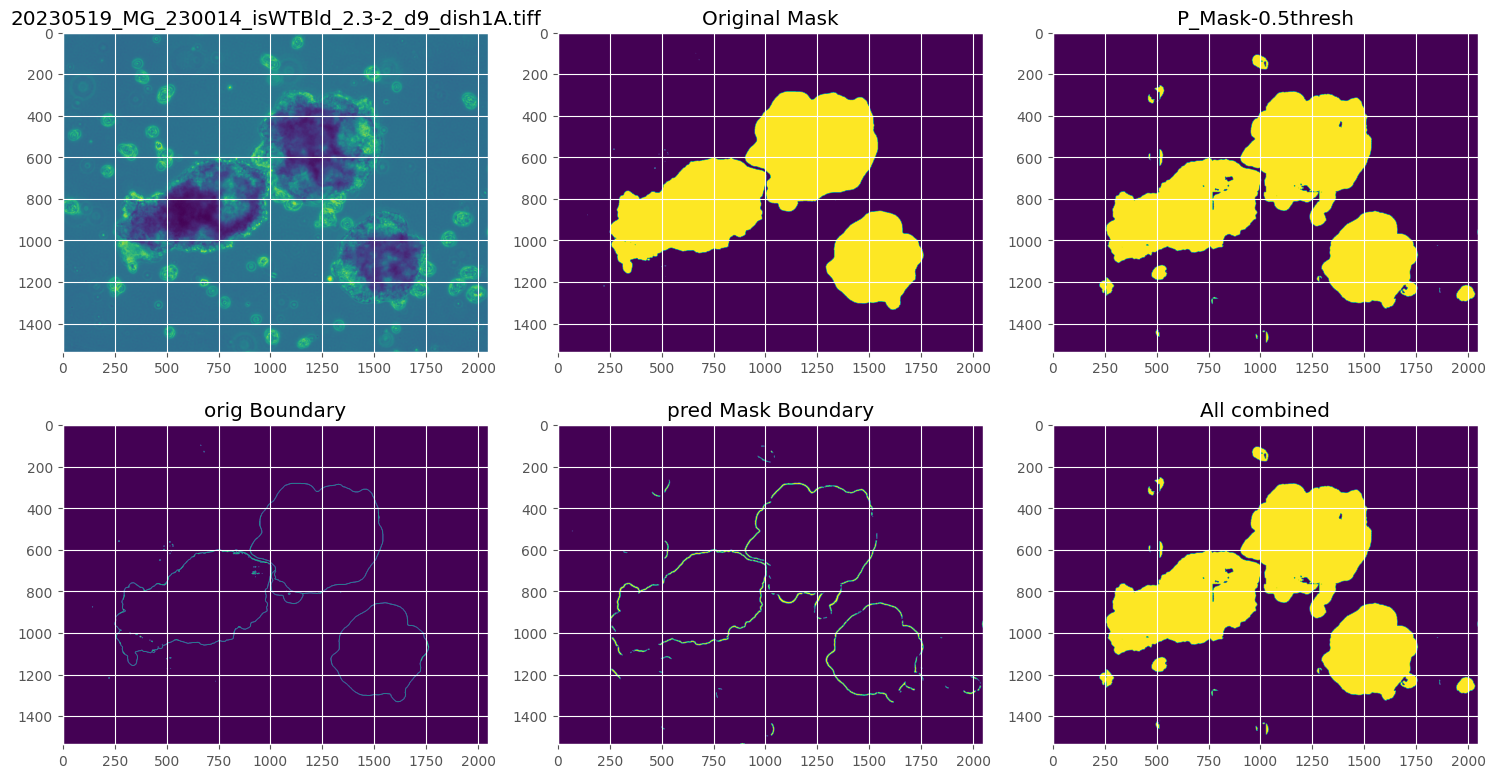

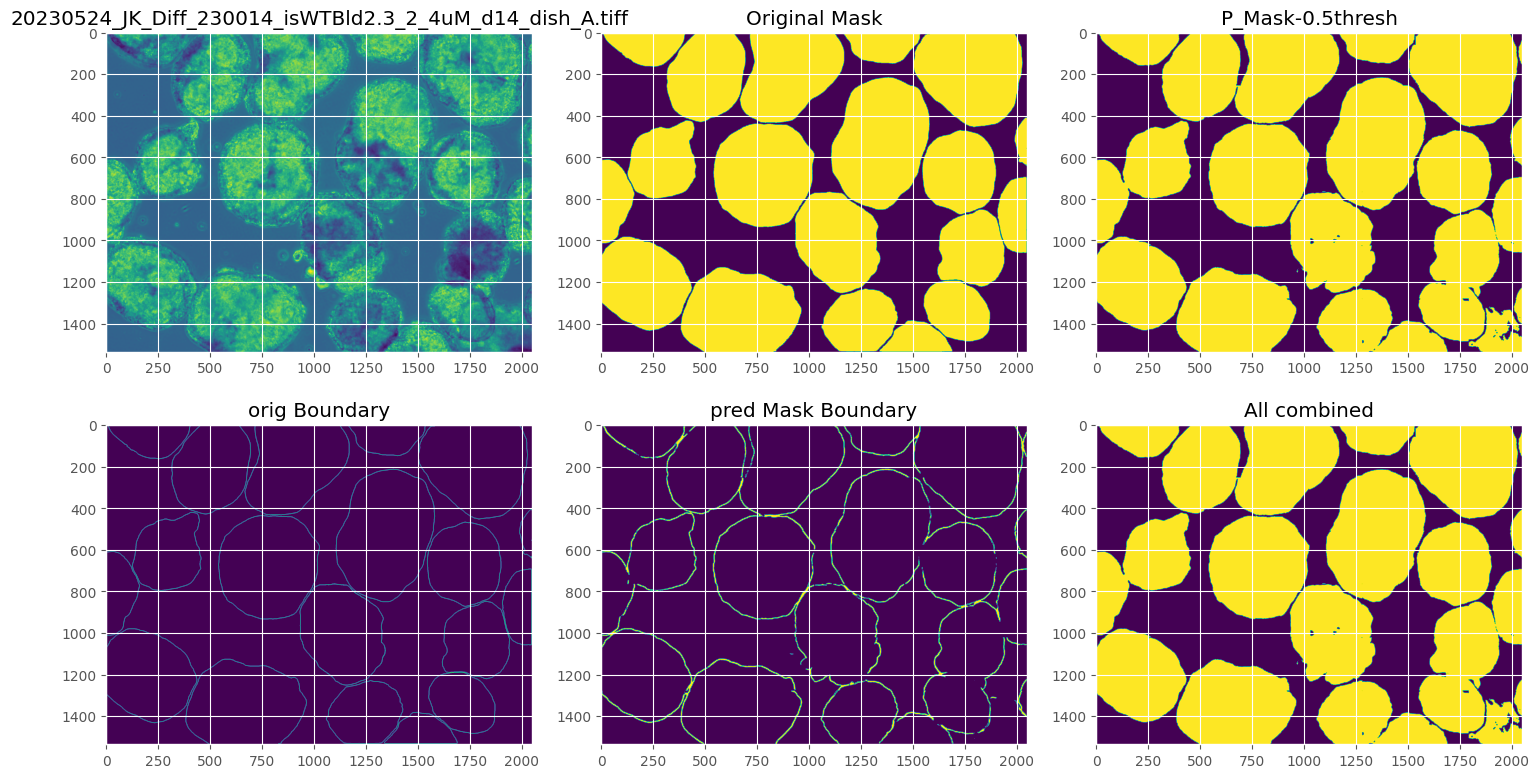

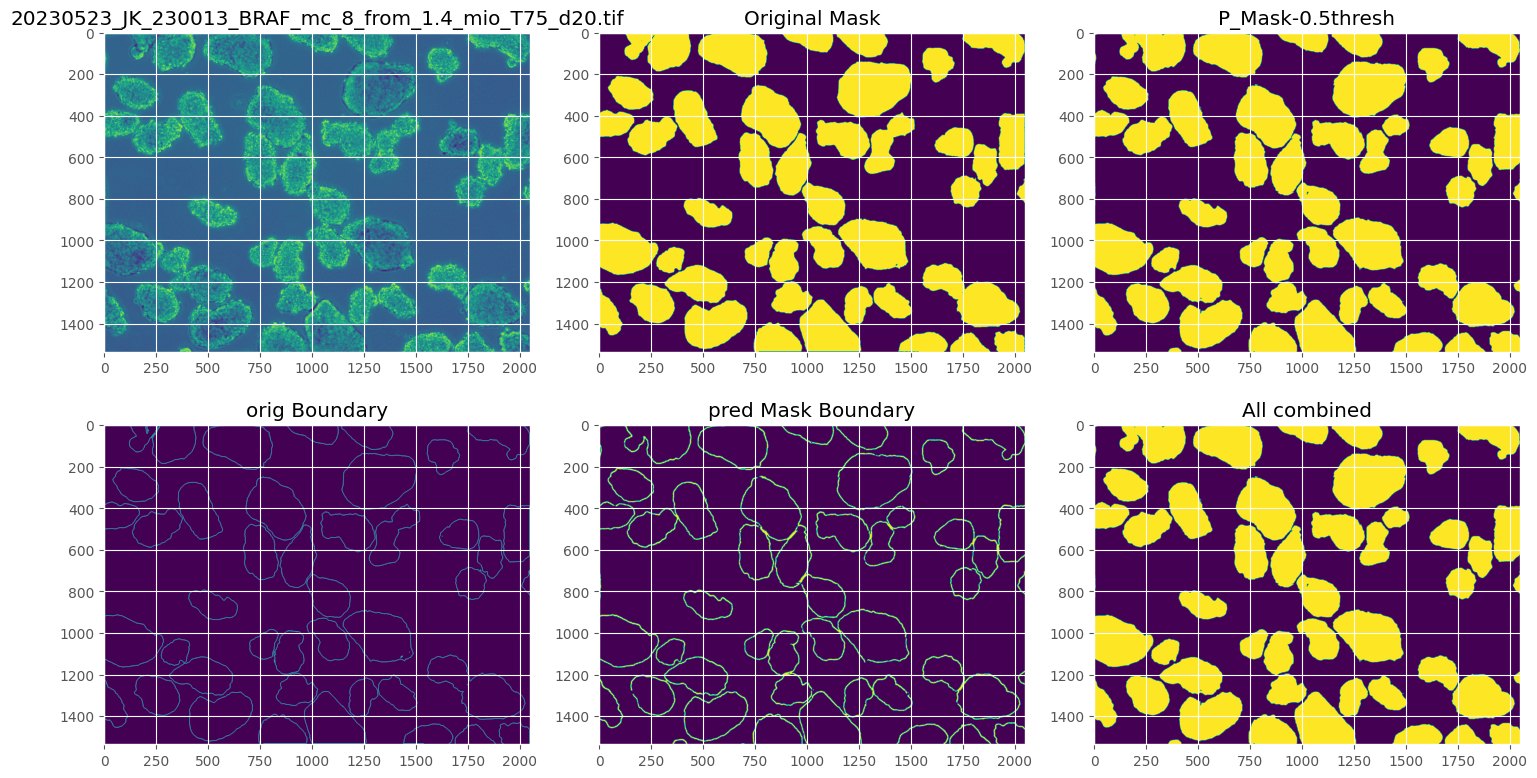

In [14]:
def loadModel(path):
    file = glob.glob("*.pth")
    print(path)
    model = torch.load(path)
    return model 

print("[INFO] load up model...")
# model = torch.load(modelFilePath).to(DEVICE)
model = loadModel(modelFilePath).to(DEVICE)
print("[INFO] loading up test image paths...\n")
test_input = '/kaggle/input/myofarm/test_inputs'
test_mask = '/kaggle/input/myofarm/test_masks'
import pickle

output_dir = "segmentation_resultOutputs"
os.makedirs(output_dir, exist_ok=True)
files = os.listdir(test_input)
for file in files:
    imagePath = test_input+ '/' + file
    groundTruthPath = test_mask + '/' + '.'.join(file.split('.')[:-1]) + '_bn.tif'
    simg, other_outputs = make_predictions(unet, file, imagePath, groundTruthPath, PATCH_SIZE, threshold = 0.5)
    
    # Create a unique filename for this output
    output_filename = os.path.join(output_dir, f"output_{file.split('.')[0]}.pkl")
    
    # Save the outputs
    with open(output_filename, 'wb') as f:
        pickle.dump({
            'image': other_outputs[0],
            'gtMask': other_outputs[1],
            'gtMask_Boundary': other_outputs[2],
            'segm_img': other_outputs[3],
            'segmBoundary_img': other_outputs[4]
        }, f)
    
    print(f"Saved output for {file} to {output_filename}")

Processing file: output_20230523_JK_230013_BRAF_mc_8_from_1.pkl
dict_keys(['image', 'gtMask', 'gtMask_Boundary', 'segm_img', 'segmBoundary_img'])


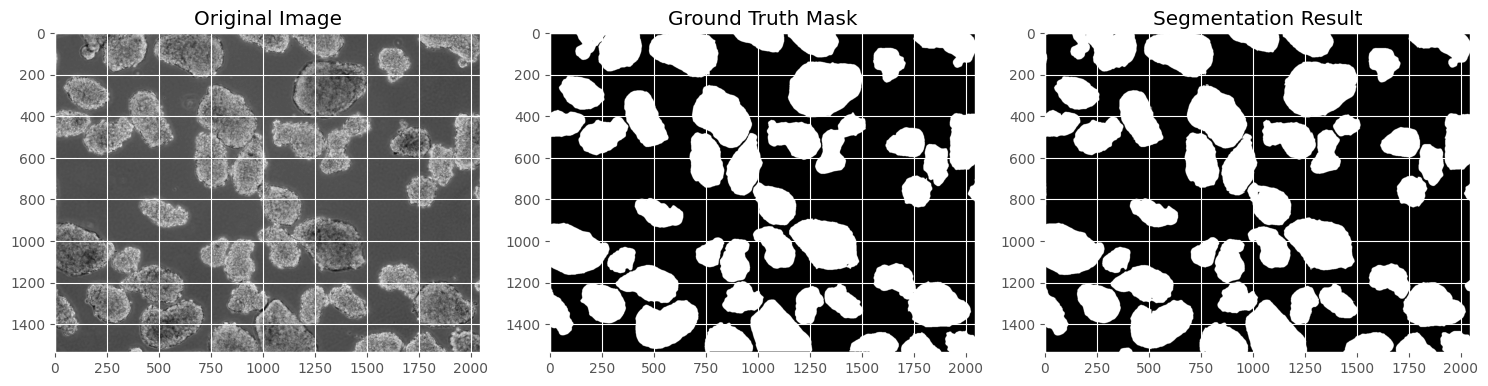

------------------------
Processing file: output_20230524_JK_Diff_230014_isWTBld2.pkl
dict_keys(['image', 'gtMask', 'gtMask_Boundary', 'segm_img', 'segmBoundary_img'])


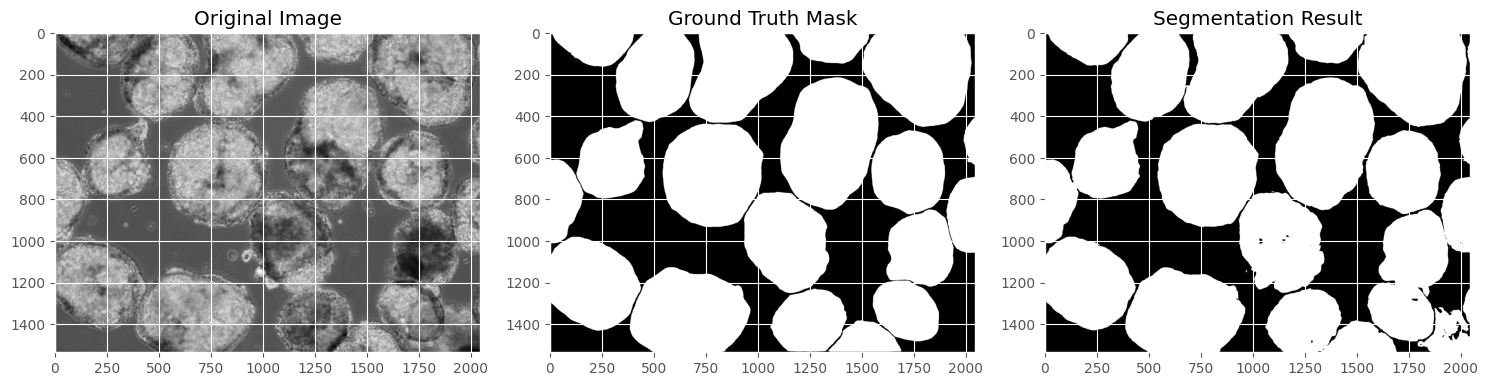

------------------------
Processing file: output_20230519_MG_230014_isWTBld_2.pkl
dict_keys(['image', 'gtMask', 'gtMask_Boundary', 'segm_img', 'segmBoundary_img'])


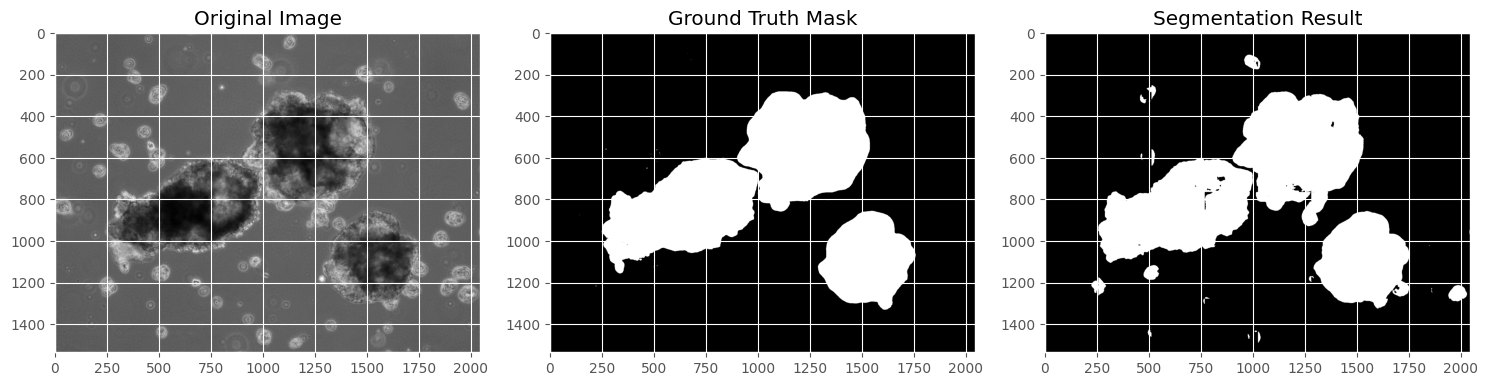

------------------------


In [15]:
import os
import pickle
import matplotlib.pyplot as plt

segmentation_op = "/kaggle/working/segmentation_resultOutputs"

for file in os.listdir(segmentation_op):
    if file.endswith('.pkl'):
        file_path = os.path.join(segmentation_op, file)
        
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        print(f"Processing file: {file}")
        print(data.keys())

        # Access individual components
        image = data['image']
        gtMask = data['gtMask']
        gtMask_Boundary = data['gtMask_Boundary'],
        segm_img = data['segm_img'] 
        segmBoundary_img = data['segmBoundary_img']
        

        
        # Visualize the results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        
        plt.subplot(132)
        plt.imshow(gtMask, cmap='gray')
        plt.title('Ground Truth Mask')
        
        plt.subplot(133)
        plt.imshow(segm_img, cmap='gray')
        plt.title('Segmentation Result')
        
        plt.tight_layout()
        plt.show()
        
        print("------------------------")

# model inference 2
## taking the same model predictions from previous cells

In [16]:
def prepare_plot(origImage, origMask, origMaskBoundary, origInstanceSegMask, combinedPredictions, predMask, predMaskBoundary, predInstances, file, threshold=None):
    figure, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 9))
    
    ax[0][0].imshow(origImage)
    ax[0][1].imshow(origMask)
    ax[0][2].imshow(origMaskBoundary)
    ax[0][3].imshow(origInstanceSegMask, cmap='nipy_spectral')
    
    ax[1][0].imshow(combinedPredictions)
    ax[1][1].imshow(predMask)
    ax[1][2].imshow(predMaskBoundary)
    ax[1][3].imshow(predInstances, cmap='nipy_spectral')

    ax[0][0].set_title(f"Original image")
    ax[0][1].set_title("Original Mask")
    ax[0][2].set_title("Original boundary")
    ax[0][3].set_title("Original Instances")
    
    ax[1][0].set_title(f"Combined predicted mask")
    ax[1][1].set_title("pred Foreground Mask")
    ax[1][2].set_title("pred Boundary")
    ax[1][3].set_title("pred Instances")

    figure.tight_layout()
    
    # Create the output directory if it doesn't exist
    save_dir = "segmentation_resultOutputs"
    os.makedirs(save_dir, exist_ok=True)
    
    # Generate a filename based on the input file
    base_name = os.path.splitext(os.path.basename(file))[0]
    save_path = os.path.join(save_dir, f"{base_name}_comparison.png")
    
    # Save the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    
def get_instances(mask):
    num_labels, labels = cv2.connectedComponents(mask)
    instances = []
    for i in range(1, num_labels):  # Skip background (0)
        instances.append(labels == i)
    return instances


def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def match_instances(pred_masks, gt_masks, iou_threshold=0.5):
    num_pred = len(pred_masks)
    num_gt = len(gt_masks)
    iou_matrix = np.zeros((num_pred, num_gt))
    
    for i in range(num_pred):
        for j in range(num_gt):
            iou_matrix[i, j] = calculate_iou(pred_masks[i], gt_masks[j])
    
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    matches = []
    for i, j in zip(row_ind, col_ind):
        if iou_matrix[i, j] >= iou_threshold:
            matches.append((i, j))
    
    return matches

def calculate_f1_score(matches, num_pred, num_gt):
    tp = len(matches)
    fp = num_pred - tp
    fn = num_gt - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1, precision, recall


Processing file: output_20230523_JK_230013_BRAF_mc_8_from_1.pkl
dict_keys(['image', 'gtMask', 'gtMask_Boundary', 'segm_img', 'segmBoundary_img'])
logically combined boundary and mask


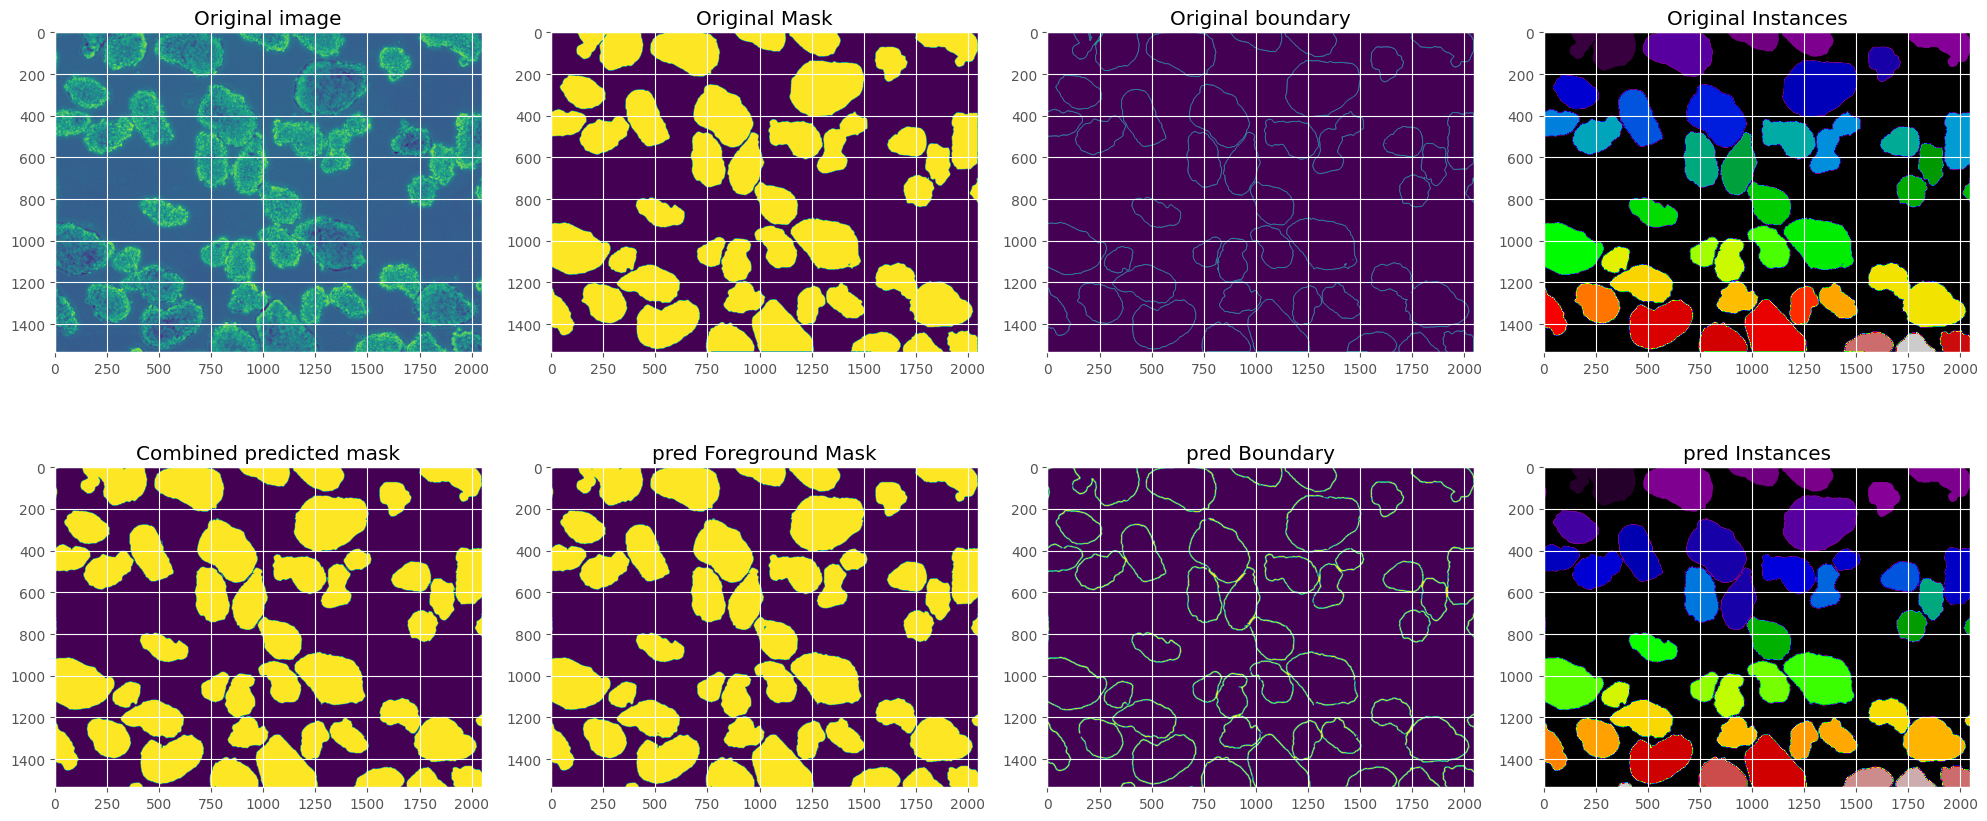

F1 Score: 0.6357
Precision: 0.4713
Recall: 0.9762
------------------------
Processing file: output_20230524_JK_Diff_230014_isWTBld2.pkl
dict_keys(['image', 'gtMask', 'gtMask_Boundary', 'segm_img', 'segmBoundary_img'])
logically combined boundary and mask


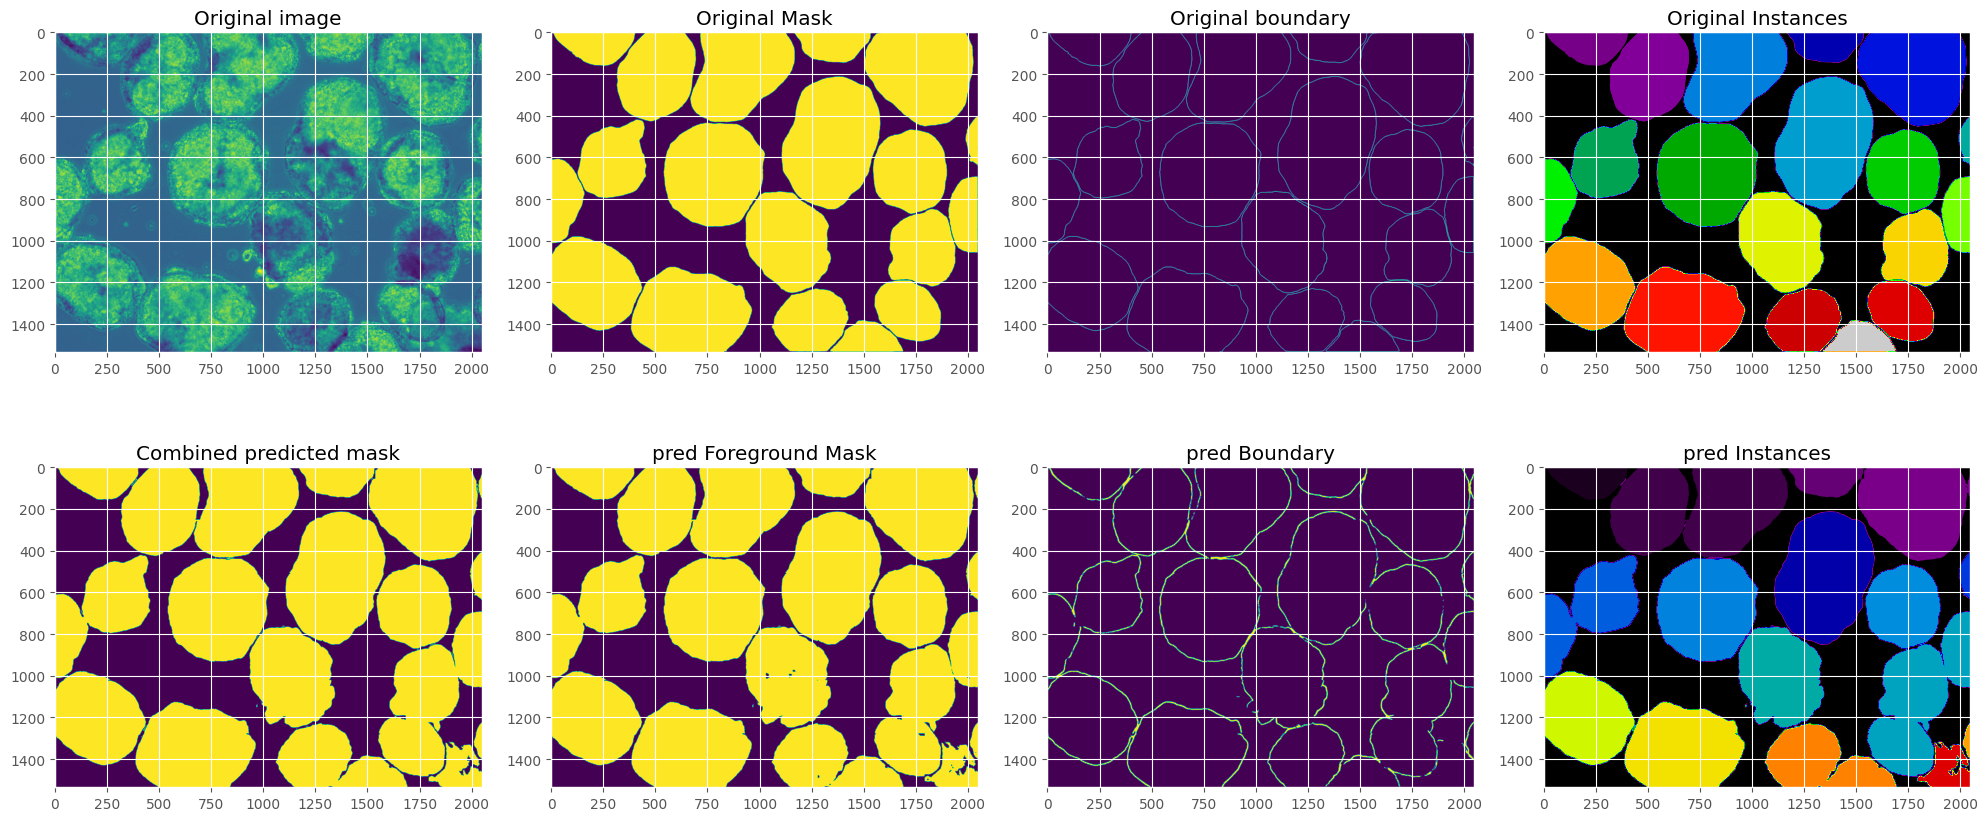

F1 Score: 0.3714
Precision: 0.2549
Recall: 0.6842
------------------------
Processing file: output_20230519_MG_230014_isWTBld_2.pkl
dict_keys(['image', 'gtMask', 'gtMask_Boundary', 'segm_img', 'segmBoundary_img'])
logically combined boundary and mask


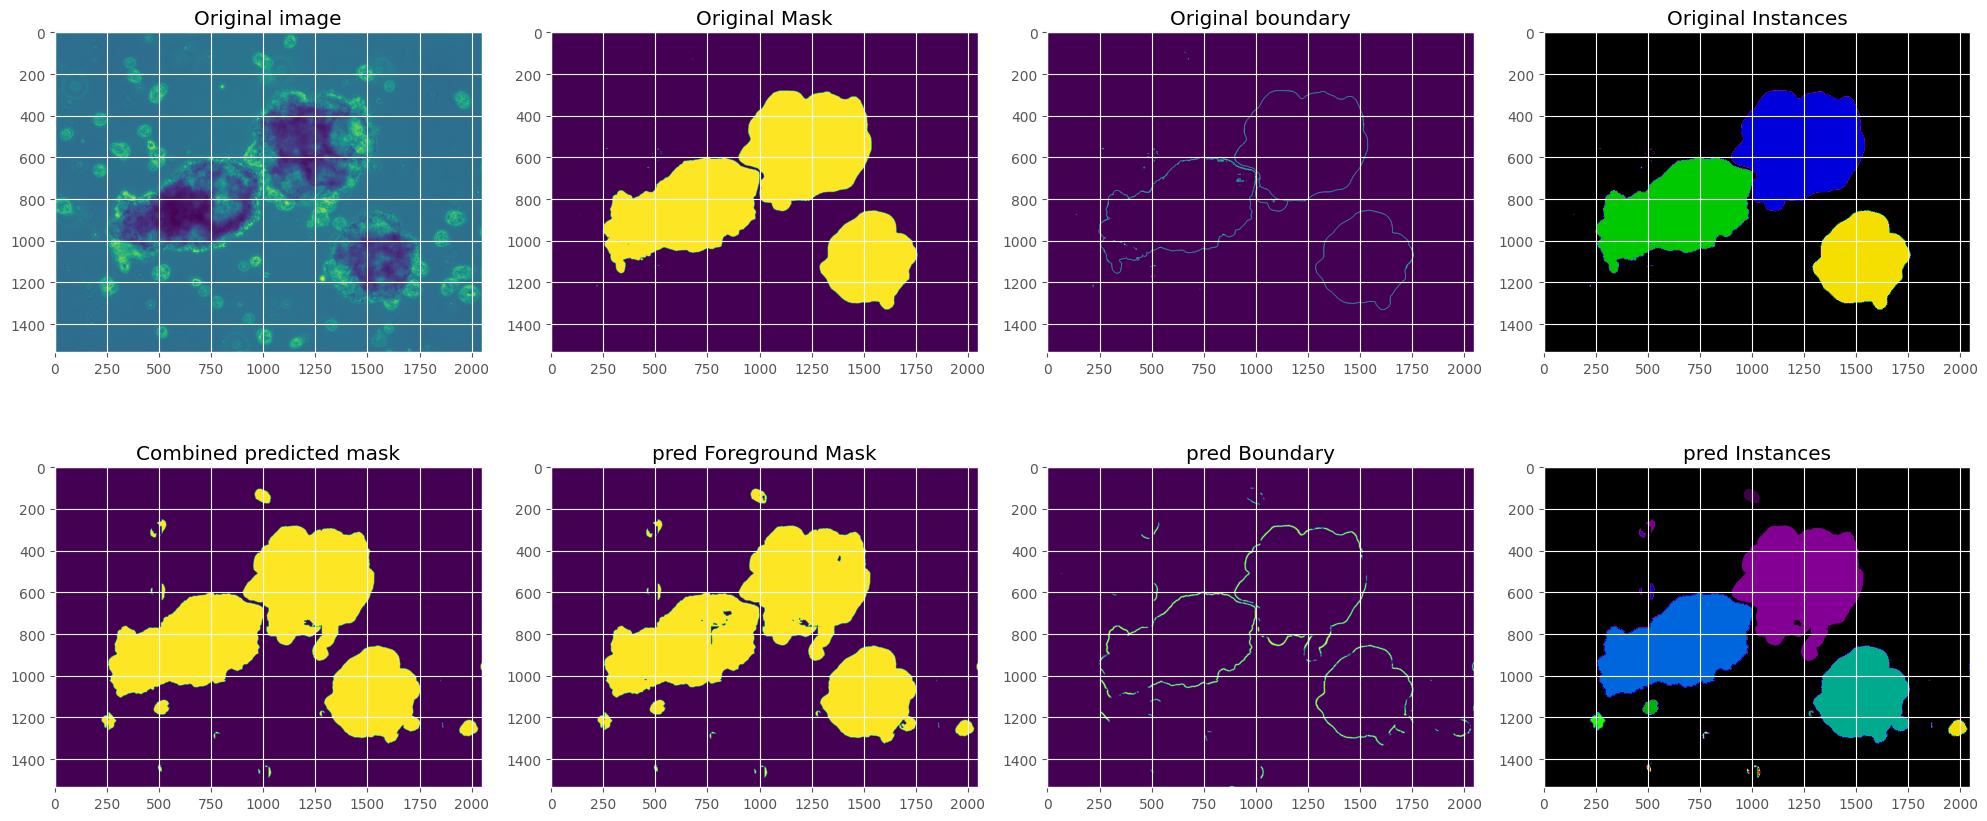

F1 Score: 0.1053
Precision: 0.0938
Recall: 0.1200
------------------------


In [17]:
import os
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import label
from scipy.optimize import linear_sum_assignment
from scipy import ndimage

segmentation_op = "/kaggle/working/segmentation_resultOutputs"

for file in os.listdir(segmentation_op):
    if file.endswith('.pkl'):
        file_path = os.path.join(segmentation_op, file)
        
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        print(f"Processing file: {file}")
        print(data.keys())

        # Access individual components
        image = data['image']
        
        gtMask = data['gtMask']
        gtMask_Boundary = data['gtMask_Boundary']
        
        segm_img = data['segm_img'] 
        segmBoundary_img = data['segmBoundary_img']
        
        origInstance, _ = label(gtMask)

        # perform erossio to get some separation between connected images 
        kernel = np.ones((5, 5), dtype=np.uint8)
        corroded_mask = cv2.erode(segm_img, kernel, iterations = 1)
        kernel = np.ones((5, 5), dtype=np.uint8)
        corrodedBoundary_mask = cv2.erode(segmBoundary_img, kernel, iterations = 2)
        
        print('logically combined boundary and mask')
        combined_predMask = np.logical_or(segm_img, corrodedBoundary_mask).astype(np.uint8) * 255
        combined_predMask = ndimage.binary_fill_holes(combined_predMask).astype(int) 
        combined_predMask = (combined_predMask > 0).astype(np.uint8) * 255
        InstanceSegMask, _ = label(combined_predMask)

        
        prepare_plot(origImage = image, 
                     origMask = gtMask, 
                     origMaskBoundary = gtMask_Boundary, 
                     origInstanceSegMask = origInstance, 
                     
                     combinedPredictions = combined_predMask, 
                     predMask = segm_img, 
                     predMaskBoundary = segmBoundary_img , 
                     predInstances = InstanceSegMask, file = file)
        
        
        # Instance segmentation evaluation
        gt_instances = get_instances(gtMask)
        pred_instances = get_instances(combined_predMask)
    
        matches = match_instances(pred_instances, gt_instances)
        f1_score, precision, recall = calculate_f1_score(matches, len(pred_instances), len(gt_instances))
    
        print(f"F1 Score: {f1_score:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print("------------------------")

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# import torch
# import cv2
# from skimage.segmentation import find_boundaries
# from scipy.ndimage import label
# from scipy.optimize import linear_sum_assignment
# import os
# import glob



# def make_predictions(model, file, imagePath, groundTruthPath, patch_size, threshold=None):
#     model.eval()
#     with torch.no_grad():
#         image = Image.open(imagePath).convert("L")
#         image = np.float32(image)/255.0
        
#         gtMask = np.array(Image.open(groundTruthPath).convert("L"))
#         gtMask[gtMask > 0] = 1.0
#         gtMask_Boundary = find_boundaries(np.array(Image.open(groundTruthPath).convert("L")), mode='thick').astype(np.uint8)
#         gtMask_Boundary[gtMask_Boundary > 0] = 1.0
    
#         height, width = image.shape[:2]
#         segm_img = np.zeros((height, width), dtype=np.uint8)
#         segmBoundary_img = np.zeros((height, width), dtype=np.uint8)
    
#         patch_num = 1
    
#         for i in range(0, height, patch_size):  
#             for j in range(0, width, patch_size):  
#                 single_patch = image[i:i+patch_size, j:j+patch_size]
#                 single_patch = np.expand_dims(np.expand_dims(single_patch, 0), 0)
#                 single_patch = torch.from_numpy(single_patch).to(DEVICE)
                
#                 single_patch_prediction, singleBoundary_patch_prediction = model(single_patch)
                
#                 single_patch_prediction = ((single_patch_prediction.squeeze().cpu().numpy() > threshold)*255).astype(np.uint8)
#                 single_patch_shape = single_patch_prediction.shape[:2]
#                 segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(single_patch_prediction, single_patch_shape[::-1])
                
#                 singleBoundary_patch_prediction = ((singleBoundary_patch_prediction.squeeze().cpu().numpy())).astype(np.uint8)
#                 single_patch_shape = singleBoundary_patch_prediction.shape[:2]
#                 segmBoundary_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(singleBoundary_patch_prediction, single_patch_shape[::-1])
            
#             patch_num += 1

#     # Get instance segmentation
#     instance_seg_mask, _ = label(segm_img)
    
#     # Instance segmentation evaluation
#     pred_instances = get_instances(segm_img)
#     gt_instances = get_instances(gtMask)
    
#     matches = match_instances(pred_instances, gt_instances)
#     f1_score, precision, recall = calculate_f1_score(matches, len(pred_instances), len(gt_instances))
    
#     prepare_plot(image, gtMask, gtMask_Boundary, segm_img, segmBoundary_img, instance_seg_mask, file, threshold)
    
#     print(f"F1 Score: {f1_score:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
    
#     return segm_img, instance_seg_mask, f1_score, precision, recall

# def loadModel(path):
#     file = glob.glob("*.pth")
#     print(path)
#     model = torch.load(path)
#     return model 

# print("[INFO] load up model...")
# model = loadModel(modelFilePath).to(DEVICE)
# print("[INFO] loading up test image paths...\n")
# test_input = '/kaggle/input/myofarm/test_inputs'
# test_mask = '/kaggle/input/myofarm/test_masks'

# files = os.listdir(test_input)
# for file in files:
#     imagePath = os.path.join(test_input, file)
#     groundTruthPath = os.path.join(test_mask, '.'.join(file.split('.')[:-1]) + '_bn.tif')
#     prediction, instance_seg_mask, f1_score, precision, recall = make_predictions(model, file, imagePath, groundTruthPath, PATCH_SIZE, threshold=0.5)
#     print(f"File: {file}")
#     print(f"F1 Score: {f1_score:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print("-------------------")